In [1]:
#!/usr/bin/python
import numpy as np
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import os
import sys
import pandas as pd

In [2]:
sys.path.append('../python/')
import tools
import scrapers
import models
import plotting
savePath="../figures/"

# Scrape and Prepare Team Data
Unlike player data, scraping team data goes pretty quick and we don't need to pre-scrape and store it locally.

In [3]:
# scrape data and store as dfs in dict
print("scraping all seasons for all teams...")
dfDict = scrapers.scrape_all_teams(tools.teamList)

scraping all seasons for all teams...
first few rows of an example data frame:
    Season   Lg   Tm   W   L Finish     Age  Ht.  Wt.  ...     FT%   ORB  \
0  2018-19  NBA  CLE  19  63      5    25.2  6-6  214  ...    .792  10.7   
1  2017-18  NBA  CLE  50  32      1    30.6  6-6  227  ...    .779   8.5   
2  2016-17  NBA  CLE  51  31      1    29.2  6-6  228  ...    .748   9.3   
3  2015-16  NBA  CLE  57  25      1    28.1  6-7  231  ...    .748  10.6   
4  2014-15  NBA  CLE  53  29      1    26.9  6-7  225  ...    .751  11.1   

    DRB   TRB   AST  STL  BLK   TOV    PF    PTS  
0  31.9  42.7  20.7  6.5  2.4  13.5  20.0  104.5  
1  33.7  42.1  23.4  7.1  3.8  13.7  18.6  110.9  
2  34.4  43.7  22.7  6.6  4.0  13.7  18.1  110.3  
3  33.9  44.5  22.7  6.7  3.9  13.6  20.3  104.3  
4  31.9  43.0  22.1  7.4  4.1  14.3  18.4  103.1  

[5 rows x 34 columns]


In [4]:
# assemble features in numpy array
featureList = ["W","PTS","2P%","2PA","3P%","3PA","FT%","FTA","ORB","DRB","AST",
               "TOV","STL","BLK","PF","Age","Ht.","Wt."]
idList, npData = models.dict_to_np_teams(dfDict, featureList)
npData         = models.scale_features(npData)

# Feature Selection and Dimensionality Reduction
The initial features have blatant redudancies, as well as more subtle redundancies.  
I use a PCA analysis to select the most meaningful features while reducing dimensionality.  
I choose to keep enough features to describe 90% of the variance of the original data.  

In [5]:
# fit pca and transform data
pca, npDataTrans = models.fit_pca(npData, 0.90)

Using 10 components explaining 90.68268039014688% of variance in original data set


# K-Means Clustering
Here I perform a clustering classification in the new vector space, classifying team's year-end stats for each season.  
In order to determine the appropriate number of clusters, I fit several choices for nClusters, measure the total distance from each point to it's cluster center, and plot these distances on an "elbow plot".  

In [6]:
nClusterList = range(1,20)
distSumsList = []
for nClusters in nClusterList:
    # run the alg in the new feature space from the pca
    kmeans = KMeans(n_clusters=nClusters)
    kmeans.fit(npDataTrans)
    # measure the sum of the distances to cluster centers for each kmeans
    totDist = np.sqrt(models.tot_sum_cluster_dists2(npDataTrans, kmeans))
    distSumsList.append(totDist)

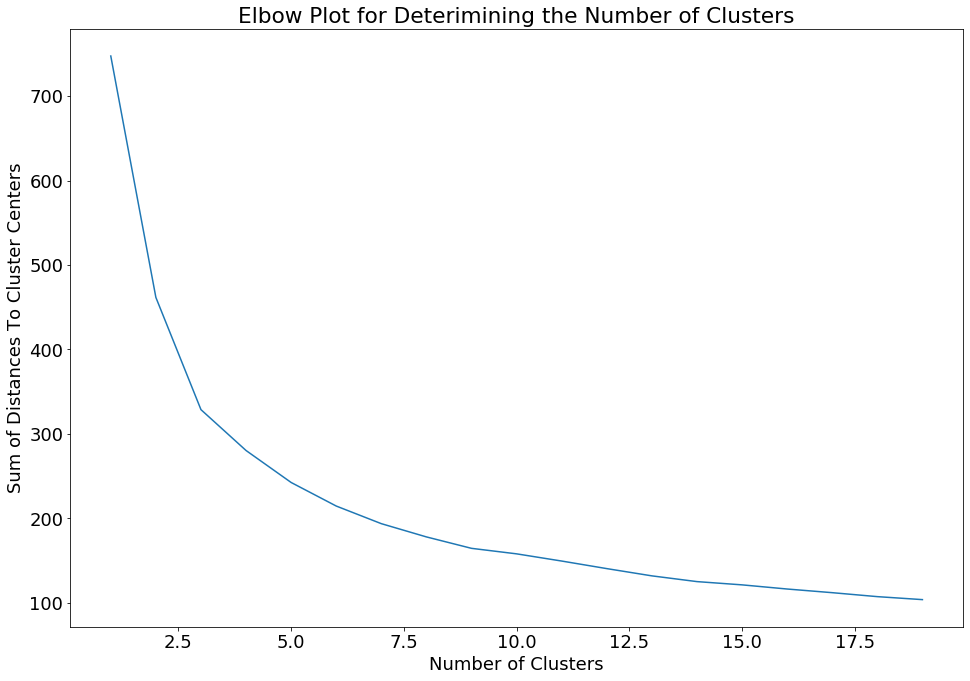

In [7]:
# make an elbow plot to determine the appropriate number of clusters
plt.plot(nClusterList, distSumsList)
plt.ylabel("Sum of Distances To Cluster Centers")
plt.xlabel("Number of Clusters")
plt.title("Elbow Plot for Deterimining the Number of Clusters");

In [8]:
# Use the plot above to select nClusters and do a final kmeans with that parameter
nClusters = 5
kmeans = KMeans(n_clusters=nClusters)
kmeans.fit(npDataTrans);

# Visualize the PCA Transformation
This new vector space is abstract, but not completely uninterpretable.  Here, I show the weights that were used to transform to the original space into the PCs we are using as features.

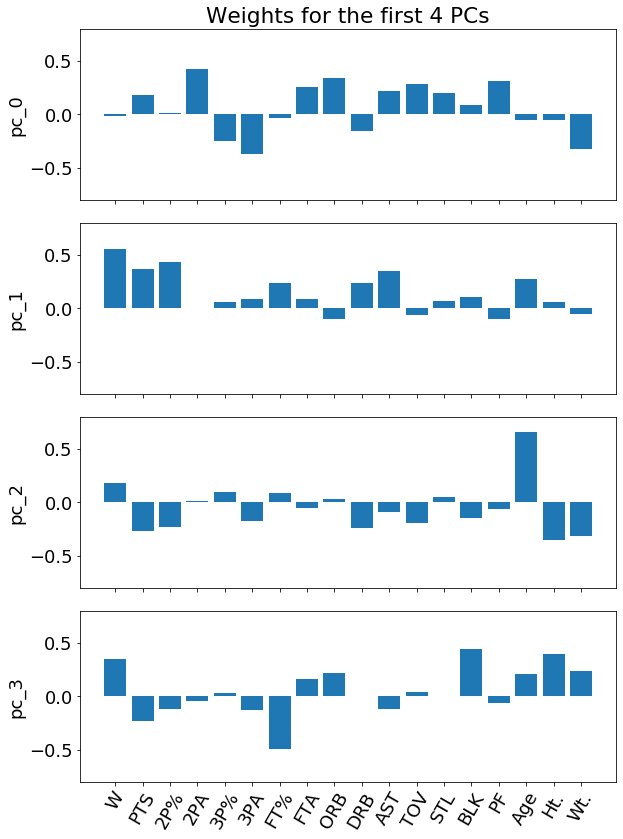

In [9]:
# visualize pca components
plt = plotting.vis_pca(pca, featureList)

# Classification by Team and Season
Now that we have each team classified for each season, let's visualize how the classifications have changed over time. Notably, we see that the playstyle has varied more over time than it varies within any given season.  All 2018 and 2019 teams belong to the same cluster. 

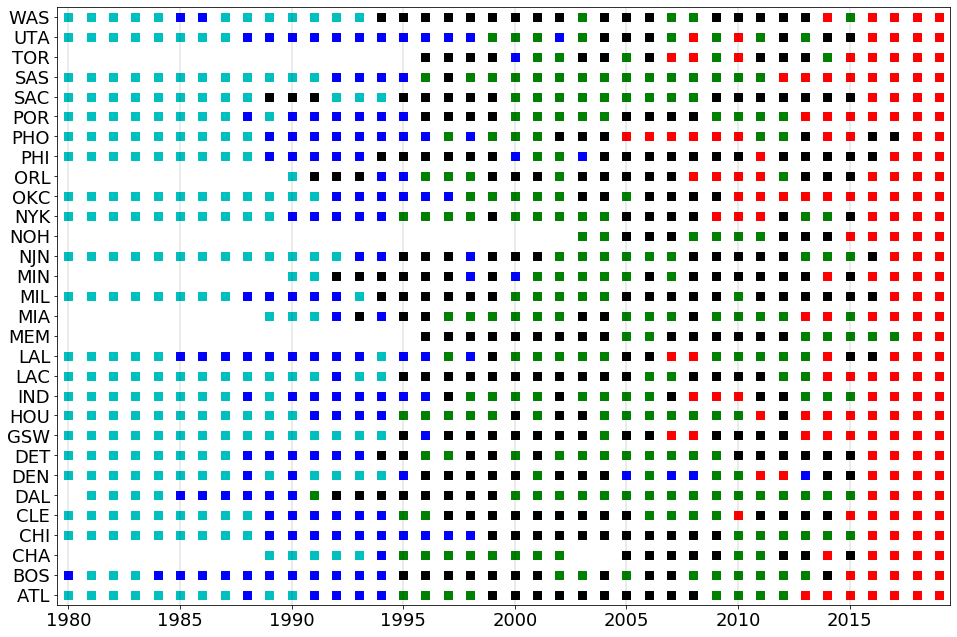

In [10]:
# plot team classifications over the years
plt = plotting.classification_plot_teams(kmeans, npDataTrans, idList)
#plt.savefig(savePath+"team_year.png", dpi=100); plt.clf();

# Add more clusters and visualize again
The above result, while interesting, is somewhat unsatisfying.  Let's add more clusters to see if we can get different classifications for modern teams to pop out.  

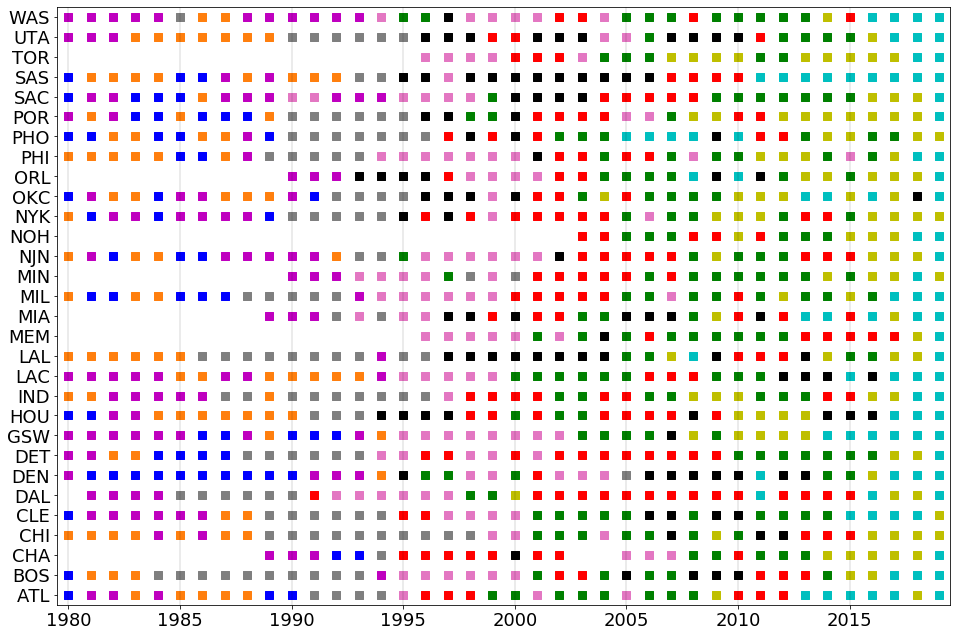

In [13]:
nClusters = 10
kmeans = KMeans(n_clusters=nClusters)
kmeans.fit(npDataTrans);
plt = plotting.classification_plot_teams(kmeans, npDataTrans, idList)